# 27 - Forward (MOSFET+Diodo+PWM): Fixed vs Variable

Comparacao do mesmo conversor com **chaveamento explicito** (`MOSFET + diodo + PWM`) em:
- `fixed step`
- `variable step`

Campanha pesada incluida para medir convergencia/custo e evidenciar limites numericos do backend em circuito comutado.


In [1]:
import time
import statistics
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import pulsim as ps

print("Pulsim:", ps.__version__)
print("Backend capabilities:", ps.backend_capabilities())


Pulsim: 0.4.1
Backend capabilities: {'klu': True, 'hypre_amg': True, 'sundials': False}


## 1) Parametros de campanha


In [2]:
CONVERTER_ID = "forward_mosfet_pwm"

# Perfil pesado (ajuste se quiser acelerar)
STRESS_HEAVY = True

BASE_TSTOP = 4e-3 if STRESS_HEAVY else 1.5e-3
BASE_DT_FIXED = 2e-6 if STRESS_HEAVY else 3e-6

print("CONVERTER_ID:", CONVERTER_ID)
print("BASE_TSTOP:", BASE_TSTOP)
print("BASE_DT_FIXED:", BASE_DT_FIXED)


CONVERTER_ID: forward_mosfet_pwm
BASE_TSTOP: 0.004
BASE_DT_FIXED: 2e-06


## 2) Construcao do circuito comutado (MOSFET + diodo + PWM)

Os parametros do dispositivo foram amaciados para manter robustez no modo `fixed` durante varreduras longas.


In [3]:
def build_converter(duty: float, fsw: float, r_load: float):
    ckt = ps.Circuit()
    gnd = ckt.ground()

    n_in = ckt.add_node("in")
    n_ctrl = ckt.add_node("ctrl")
    n_pri = ckt.add_node("pri")
    n_sec = ckt.add_node("sec")
    n_rect = ckt.add_node("rect")
    n_out = ckt.add_node("out")

    ckt.add_voltage_source("Vin", n_in, gnd, 30.0)

    m = ps.MOSFETParams()
    m.vth = 2.0
    m.kp = 0.002
    m.g_off = 1e-3
    m.lambda_ = 0.0
    ckt.add_mosfet("M1", n_ctrl, n_in, n_pri, m)

    ckt.add_transformer("T1", n_pri, gnd, n_sec, gnd, 0.8)
    ckt.add_diode("D_fwd", n_sec, n_rect, 5.0, 1e-4)
    ckt.add_diode("D_free", gnd, n_rect, 5.0, 1e-4)

    ckt.add_inductor("Lout", n_rect, n_out, 220e-6, 0.0)
    ckt.add_capacitor("Cout", n_out, gnd, 220e-6, 0.0)
    ckt.add_resistor("Rload", n_out, gnd, float(r_load))

    ckt.add_resistor("Rb_pri", n_pri, gnd, 1e5)
    ckt.add_resistor("Rb_sec", n_sec, gnd, 1e5)
    ckt.add_resistor("Rb_rect", n_rect, gnd, 1e5)

    pwm = ps.PWMParams()
    pwm.v_high = 10.0
    pwm.v_low = 0.0
    pwm.frequency = float(fsw)
    pwm.duty = float(duty)
    pwm.rise_time = 3e-6
    pwm.fall_time = 3e-6
    ckt.add_pwm_voltage_source("Vpwm", n_ctrl, gnd, pwm)

    return ckt, {"n_out_name": "out", "n_sw_name": "pri"}


## 3) Solver setup e funcao de execucao

- `fixed`: `BDF1` com passo fixo estrito
- `variable`: modo adaptativo canonico do backend


In [4]:
def build_options(step_mode: str, tstop: float, dt_fixed: float):
    opts = ps.SimulationOptions()
    opts.tstart = 0.0
    opts.tstop = float(tstop)
    opts.dt = float(dt_fixed)

    opts.transient_backend = ps.TransientBackendMode.Native
    opts.newton_options.max_iterations = 220
    opts.newton_options.auto_damping = True
    opts.linear_solver.allow_fallback = True
    opts.linear_solver.auto_select = True
    opts.max_step_retries = 35

    if step_mode == "fixed":
        opts.step_mode = ps.StepMode.Fixed
        opts.integrator = ps.Integrator.BDF1
        opts.dt_min = opts.dt
        opts.dt_max = opts.dt
    else:
        opts.step_mode = ps.StepMode.Variable

    return opts


def signal_index(circuit: ps.Circuit, node_name: str) -> int:
    names = [n.lower() for n in circuit.signal_names()]
    target = f"v({node_name.lower()})"
    if target not in names:
        raise ValueError(f"Sinal {target} nao encontrado em {circuit.signal_names()}")
    return names.index(target)


def run_case(step_mode: str, duty: float, fsw: float, r_load: float, tstop: float, dt_fixed: float):
    ckt, nodes = build_converter(duty=duty, fsw=fsw, r_load=r_load)
    opts = build_options(step_mode=step_mode, tstop=tstop, dt_fixed=dt_fixed)

    sim = ps.Simulator(ckt, opts)
    x0 = ckt.initial_state()  # evita variacao de DC-op entre casos

    t0 = time.perf_counter()
    res = sim.run_transient(x0)
    elapsed = time.perf_counter() - t0

    out = {
        "mode": step_mode,
        "success": bool(res.success),
        "message": str(res.message),
        "elapsed_s": float(elapsed),
        "steps": int(res.total_steps),
        "rejections": int(res.timestep_rejections),
        "newton_total": int(res.newton_iterations_total),
        "time": np.asarray(res.time, dtype=float),
        "vout": np.array([], dtype=float),
        "vsw": np.array([], dtype=float),
    }

    if res.success and len(res.time) > 5 and len(res.states) > 5:
        states = np.asarray(res.states, dtype=float)
        idx_out = signal_index(ckt, nodes["n_out_name"])
        idx_sw = signal_index(ckt, nodes["n_sw_name"])

        vout = states[:, idx_out]
        vsw = states[:, idx_sw]
        out["vout"] = vout
        out["vsw"] = vsw

        tail = max(10, int(0.2 * len(vout)))
        seg = vout[-tail:]
        out["vout_final"] = float(vout[-1])
        out["vout_mean_tail"] = float(np.mean(seg))
        out["vout_ripple_tail"] = float(np.max(seg) - np.min(seg))
    else:
        out["vout_final"] = float("nan")
        out["vout_mean_tail"] = float("nan")
        out["vout_ripple_tail"] = float("nan")

    return out


## 4) Caso base (same converter, fixed vs variable)


In [5]:
base_scenario = {"name": "W0", "duty": 0.12, "fsw": 5.5e3, "r_load": 10.0}

scenarios = [
    {"name": "W1", "duty": 0.08, "fsw": 4e3,   "r_load": 8.0},
    {"name": "W2", "duty": 0.10, "fsw": 5e3,   "r_load": 9.0},
    {"name": "W3", "duty": 0.12, "fsw": 5.5e3, "r_load": 10.0},
    {"name": "W4", "duty": 0.14, "fsw": 6e3,   "r_load": 11.0},
    {"name": "W5", "duty": 0.16, "fsw": 7e3,   "r_load": 12.0},
    {"name": "W6", "duty": 0.18, "fsw": 8e3,   "r_load": 14.0},
]


In [6]:
base_fixed = run_case(
    step_mode="fixed",
    duty=base_scenario["duty"],
    fsw=base_scenario["fsw"],
    r_load=base_scenario["r_load"],
    tstop=BASE_TSTOP,
    dt_fixed=BASE_DT_FIXED,
)

base_variable = run_case(
    step_mode="variable",
    duty=base_scenario["duty"],
    fsw=base_scenario["fsw"],
    r_load=base_scenario["r_load"],
    tstop=BASE_TSTOP,
    dt_fixed=BASE_DT_FIXED,
)

for item in (base_fixed, base_variable):
    print("-" * 72)
    print("mode:", item["mode"])
    print("success:", item["success"])
    print("message:", item["message"])
    print("elapsed_s:", f"{item['elapsed_s']:.4f}")
    print("steps:", item["steps"], "rejections:", item["rejections"], "newton_total:", item["newton_total"])
    if item["success"]:
        print("vout_final:", f"{item['vout_final']:.4f} V")
        print("vout_mean_tail:", f"{item['vout_mean_tail']:.4f} V")
        print("vout_ripple_tail:", f"{item['vout_ripple_tail']*1e3:.3f} mV")


------------------------------------------------------------------------
mode: fixed
success: True
message: Transient completed
elapsed_s: 0.0867
steps: 2000 rejections: 0 newton_total: 20025
vout_final: 0.2073 V
vout_mean_tail: 0.2103 V
vout_ripple_tail: 14.109 mV
------------------------------------------------------------------------
mode: variable
success: False
message: Transient failed at t=0.000003: Max iterations reached (automatic regularization attempted)
elapsed_s: 0.0368
steps: 2 rejections: 108 newton_total: 27


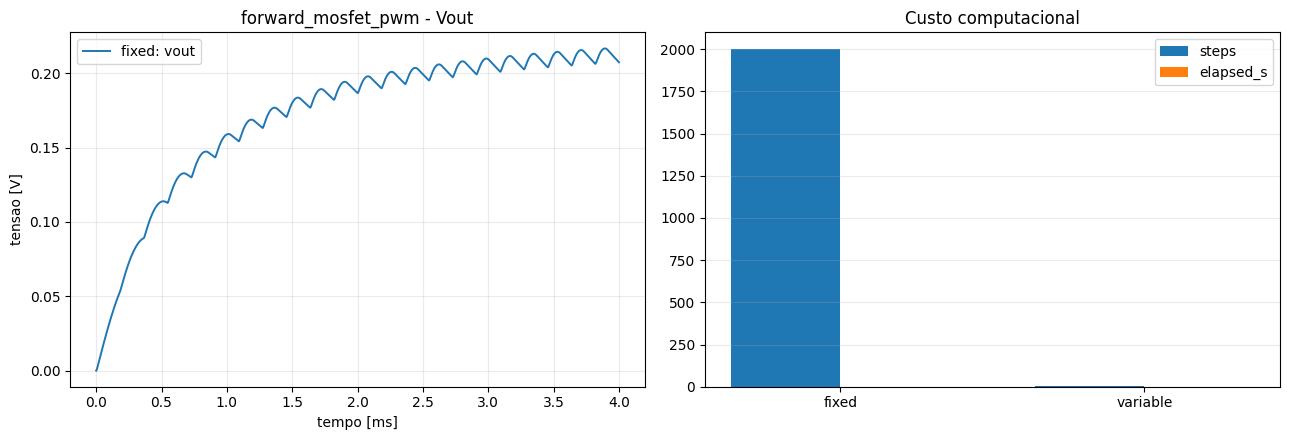

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))

if base_fixed["success"]:
    ax[0].plot(base_fixed["time"] * 1e3, base_fixed["vout"], lw=1.4, label="fixed: vout")
if base_variable["success"]:
    ax[0].plot(base_variable["time"] * 1e3, base_variable["vout"], lw=1.2, label="variable: vout")

ax[0].set_title(f"{CONVERTER_ID} - Vout")
ax[0].set_xlabel("tempo [ms]")
ax[0].set_ylabel("tensao [V]")
ax[0].grid(True, alpha=0.25)
ax[0].legend()

labels = ["fixed", "variable"]
steps = [base_fixed["steps"], base_variable["steps"]]
elapsed = [base_fixed["elapsed_s"], base_variable["elapsed_s"]]

x = np.arange(len(labels))
bw = 0.36
ax[1].bar(x - bw/2, steps, width=bw, label="steps")
ax[1].bar(x + bw/2, elapsed, width=bw, label="elapsed_s")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_title("Custo computacional")
ax[1].grid(True, axis="y", alpha=0.25)
ax[1].legend()

plt.tight_layout()
plt.show()


## 5) Campanha pesada de estresse


In [8]:
campaign_results = []
for sc in scenarios:
    for mode in ("fixed", "variable"):
        result = run_case(
            step_mode=mode,
            duty=sc["duty"],
            fsw=sc["fsw"],
            r_load=sc["r_load"],
            tstop=BASE_TSTOP,
            dt_fixed=BASE_DT_FIXED,
        )
        result["scenario"] = sc["name"]
        result["duty"] = sc["duty"]
        result["fsw"] = sc["fsw"]
        result["r_load"] = sc["r_load"]
        campaign_results.append(result)

print("Casos executados:", len(campaign_results))


Casos executados: 12


In [9]:
def summarize_mode(results, mode):
    data = [r for r in results if r["mode"] == mode]
    ok = [r for r in data if r["success"]]
    fail = [r for r in data if not r["success"]]

    success_rate = (len(ok) / max(1, len(data))) * 100.0
    med_elapsed = statistics.median([r["elapsed_s"] for r in data]) if data else float("nan")
    med_steps = statistics.median([r["steps"] for r in data]) if data else float("nan")
    med_rej = statistics.median([r["rejections"] for r in data]) if data else float("nan")

    fail_msgs = Counter(r["message"] for r in fail)
    top_fail = fail_msgs.most_common(3)

    return {
        "mode": mode,
        "n": len(data),
        "n_ok": len(ok),
        "n_fail": len(fail),
        "success_rate": success_rate,
        "median_elapsed_s": med_elapsed,
        "median_steps": med_steps,
        "median_rejections": med_rej,
        "top_fail": top_fail,
    }


sum_fixed = summarize_mode(campaign_results, "fixed")
sum_variable = summarize_mode(campaign_results, "variable")

for s in (sum_fixed, sum_variable):
    print("=" * 76)
    print("mode:", s["mode"])
    print("casos:", s["n"], "ok:", s["n_ok"], "fail:", s["n_fail"], "success_rate:", f"{s['success_rate']:.1f}%")
    print("median_elapsed_s:", f"{s['median_elapsed_s']:.4f}")
    print("median_steps:", int(s["median_steps"]))
    print("median_rejections:", int(s["median_rejections"]))
    if s["n_fail"] > 0:
        print("top_fail_messages:")
        for msg, cnt in s["top_fail"]:
            print(f"  - {cnt}x {msg}")

if sum_fixed["n_ok"] > 0 and sum_variable["n_ok"] > 0:
    speedup = sum_fixed["median_elapsed_s"] / max(1e-12, sum_variable["median_elapsed_s"])
    step_reduction = sum_fixed["median_steps"] / max(1e-12, sum_variable["median_steps"])
    print("=" * 76)
    print(f"speedup mediano (fixed/variable): {speedup:.2f}x")
    print(f"reducao mediana de passos (fixed/variable): {step_reduction:.2f}x")
else:
    print("=" * 76)
    print("Comparacao direta de speedup nao disponivel (um dos modos nao convergiu em nenhum caso).")


mode: fixed
casos: 6 ok: 6 fail: 0 success_rate: 100.0%
median_elapsed_s: 0.0897
median_steps: 2000
median_rejections: 0
mode: variable
casos: 6 ok: 0 fail: 6 success_rate: 0.0%
median_elapsed_s: 0.0368
median_steps: 2
median_rejections: 108
top_fail_messages:
  - 6x Transient failed at t=0.000003: Max iterations reached (automatic regularization attempted)
Comparacao direta de speedup nao disponivel (um dos modos nao convergiu em nenhum caso).


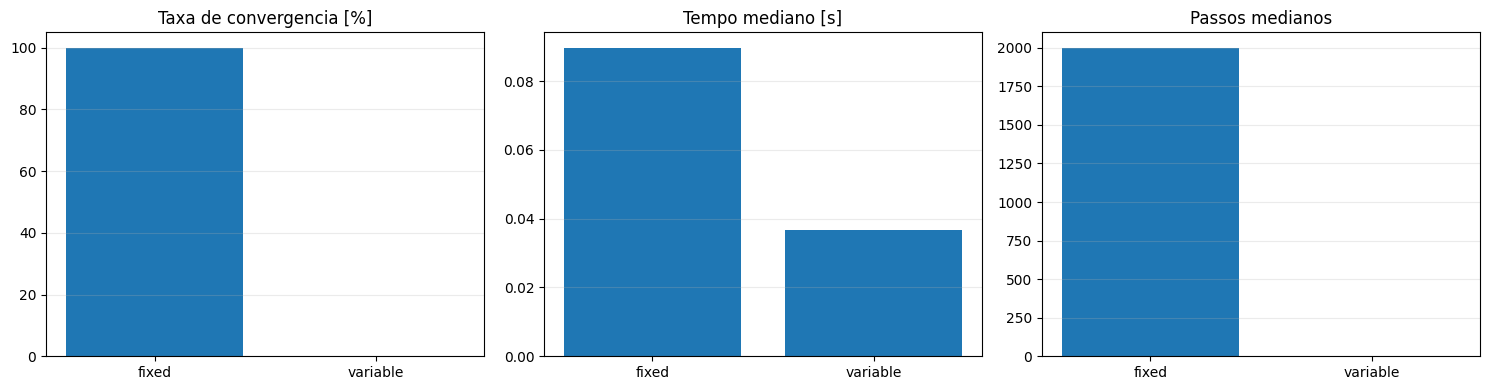

In [10]:
labels = ["fixed", "variable"]
summary = [sum_fixed, sum_variable]

success_rate = [s["success_rate"] for s in summary]
med_elapsed = [s["median_elapsed_s"] for s in summary]
med_steps = [s["median_steps"] for s in summary]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].bar(labels, success_rate)
ax[0].set_ylim([0, 105])
ax[0].set_title("Taxa de convergencia [%]")
ax[0].grid(True, axis="y", alpha=0.25)

ax[1].bar(labels, med_elapsed)
ax[1].set_title("Tempo mediano [s]")
ax[1].grid(True, axis="y", alpha=0.25)

ax[2].bar(labels, med_steps)
ax[2].set_title("Passos medianos")
ax[2].grid(True, axis="y", alpha=0.25)

plt.tight_layout()
plt.show()
